# Análisis de Ice shop
## Objetivo

Analizar las reseñas de usuarios y expertos, los géneros, las plataformas (por ejemplo, Xbox o PlayStation) y los datos históricos sobre las ventas de juegos para identificar patrones que determinen si un juego tiene éxito o no. Esto con el fin de detectar proyectos prometedores y planificar campañas publicitarias.

Los datos se remontan a 2016.

<span style="color: gold;">**Nota:**</span>
El dataset contiene una columna "rating" que almacena la clasificación ESRB de cada juego. El Entertainment Software Rating Board (la Junta de clasificación de software de entretenimiento) evalúa el contenido de un juego y asigna una clasificación de edad como Adolescente o Adulto.

## Diccionario de datos

— Name (Nombre)

— Platform (Plataforma)

— Year_of_Release (Año de lanzamiento)

— Genre (Género) 

— NA_sales (ventas en Norteamérica en millones de dólares estadounidenses) 

— EU_sales (ventas en Europa en millones de dólares estadounidenses) 

— JP_sales (ventas en Japón en millones de dólares estadounidenses) 

— Other_sales (ventas en otros países en millones de dólares estadounidenses) 

— Critic_Score (máximo de 100) 

— User_Score (máximo de 10) 

— Rating (ESRB)

Es posible que los datos de 2016 estén incompletos.

## Pasos a seguir:

* Importar los archivos
* Limpieza de datos
* Análisis exploratorio
* Visualización: cómo varían las ventas de una plataforma a otra
* Determinar período para la toma de datos
* Visualización: distribución en las ventas
* Crear un perfil de usuario para cada región
* Prueba de hipótesis: influencia diferencia en las calificaciones de usuarios por plataforma y género

In [ ]:

# Importar las librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
from scipy.stats import levene

## Visualización general de los datos

In [ ]:
# Importar los datos de juegos 
games=pd.read_csv('games.csv')

In [76]:
# Información general del dataframe
games.info()
print('\n',games.sample(5))
print('\n','Hay',games.duplicated().sum(),'filas duplicadas')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB

                                                     Name Platform  \
6100                  Dragon Ball Z: Budokai Tenkaichi 2      Wii   
13307  Venus & Braves: Majo to Megami to Horobi no Yogen      PSP   
2635                           J

## Comentario

En un primer vistazo, en cuanto al nombre de las columnas, sería apropiado convertirlos a minúsculas. También los datos presetan valores ausentes y no hay filas duplicadas.

En cuanto a los tipos de datos, se deberían de cambiar los siguientes:
* **year_of_release** a `int`
* **critic_score** a `int` (verificar)

La columna "user_score" aparentemente combina letras y números, necesita verificarse lo que indicaría esto.

## Limpieza de datos

### Conversión de datos:

In [77]:
# Nombres de las columnas y columnas a minúsculas
games.columns=games.columns.str.lower()
games['name']=games['name'].str.lower()
games['genre']=games['genre'].str.lower()

In [78]:
# Columna "year_of_release" a int
games['year_of_release']=games['year_of_release'].astype('Int64')

In [79]:
# Columna "user_score" a float
games['user_score']=pd.to_numeric(games['user_score'], errors='coerce')

* Se convertieron a minúsculas como buena práctica al evitar los errores causados por la mezcla entre mayúsculas y minúsculas, facilitando la escritura.
* La columna "year_of_release" se convirtió a `Int64` porque este valor acepta la presencia de valores ausentes, al dejar los valores nulos se evitan distorciones en los análisis posteriores.
* La columna "user_score" se convirtió a `float` mediante `.to_numeric` con el parámetro en `coerce` para convertir el score a número y la abreviatura "TBD" a nulo. La abreviatura al expresar que son valores que siguen sin conocerse ("a determinar") se puede prescindir de ella.

### Manejo de nulos:

In [80]:
# Columna "name"
games.fillna({'name':'unknow'}, inplace=True)

In [81]:
# Columna "genre"
games.fillna({'genre':'unknow'}, inplace=True)

Para los valores nulos en las columnas de género y nombre, se rellenaron con "unknow" porque son valores que no se conocen y se pueden evitar los nulos sin alterar los resultados de análisis posteriores.

### Ventas totales

In [82]:
# Total de ventas por juego
games['total_sales']=games['na_sales']+games['eu_sales']+games['jp_sales']+games['other_sales']

**Comentario**

Los valores nulos restantes en las columnas de critic_score, user_score y rating se pueden deber a falta de documentación en las plataformas, la baja participación de los usuarios en calificar los juegos y en la actual evaluación para la clasificación ESRB. Estos datos se mantienen en nulo ya que al asignarles un valor se estaría influyendo en el análisis posterior.

## Análisis exploratorio

### Juegos lanzados por año

In [83]:
# Juegos lanzados por año
games_per_year=games.groupby('year_of_release')['name'].count()

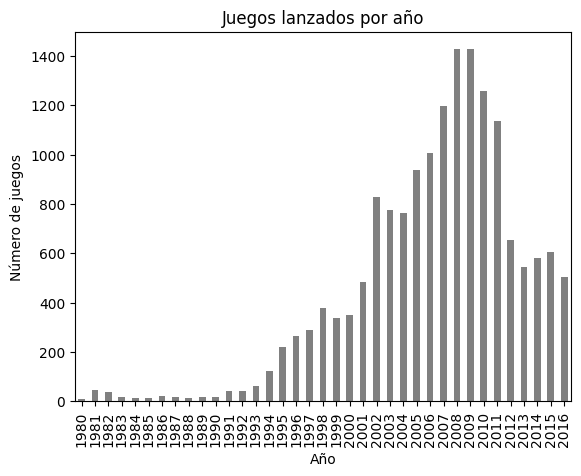

In [84]:
games_per_year.plot(kind='bar',
                    title='Juegos lanzados por año',
                    ylabel='Número de juegos',
                    xlabel='Año', color='grey')
plt.show()

**Comentario**

Los años 2008 y 2009 fueron en los que hubo mayor lanzamiento de videojuegos

### Ventas por plataforma

In [85]:
# Ventas totales por plataforma
sales_per_platform=games.groupby('platform')['total_sales'].sum().sort_values(ascending=False).reset_index()

# Top 10 plataformas con mayores ingresos totales
top_10_platforms=sales_per_platform[:10]

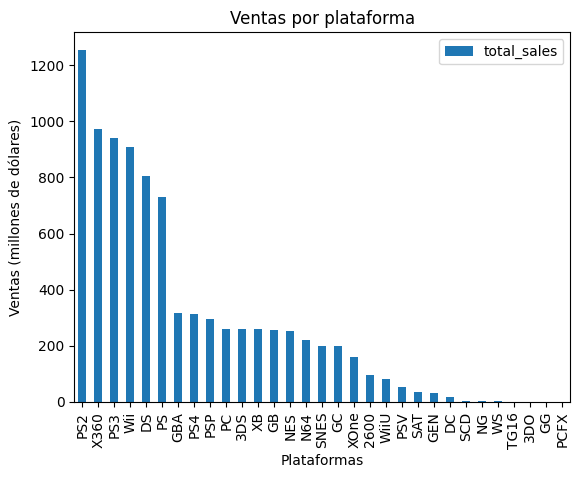

In [86]:
sales_per_platform.plot(kind='bar',
                      title='Ventas por plataforma',
                      x='platform',
                      y='total_sales',
                      ylabel='Ventas (millones de dólares)',
                      xlabel='Plataformas')
plt.show()

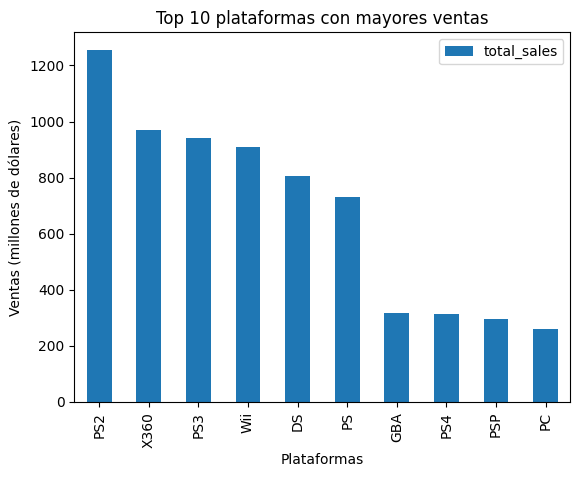

In [87]:
top_10_platforms.plot(kind='bar',
                      title='Top 10 plataformas con mayores ventas',
                      x='platform',
                      y='total_sales',
                      ylabel='Ventas (millones de dólares)',
                      xlabel='Plataformas')
plt.show()

In [88]:
# Lista del top 10 de plataformas
platforms_list=top_10_platforms['platform'].to_list()

In [89]:
# Función para crear la gráfica del top 10 de plataformas
def platform_history_per_year(df,platforms):
    
    platform_filter=df[df['platform'].isin(platforms)]
    
    sales_per_year=platform_filter.groupby(['year_of_release','platform'])['total_sales'].sum().unstack(fill_value=0) 
    
    sales_per_year.plot(kind='line',
                        title='Histórico de mayores ventas anuales por plataforma',
                        xlabel='Año de lanzamiento',
                        ylabel='Ventas (millones de dólares)',
                        figsize=(14,8),
                        style='-o')
    plt.show()

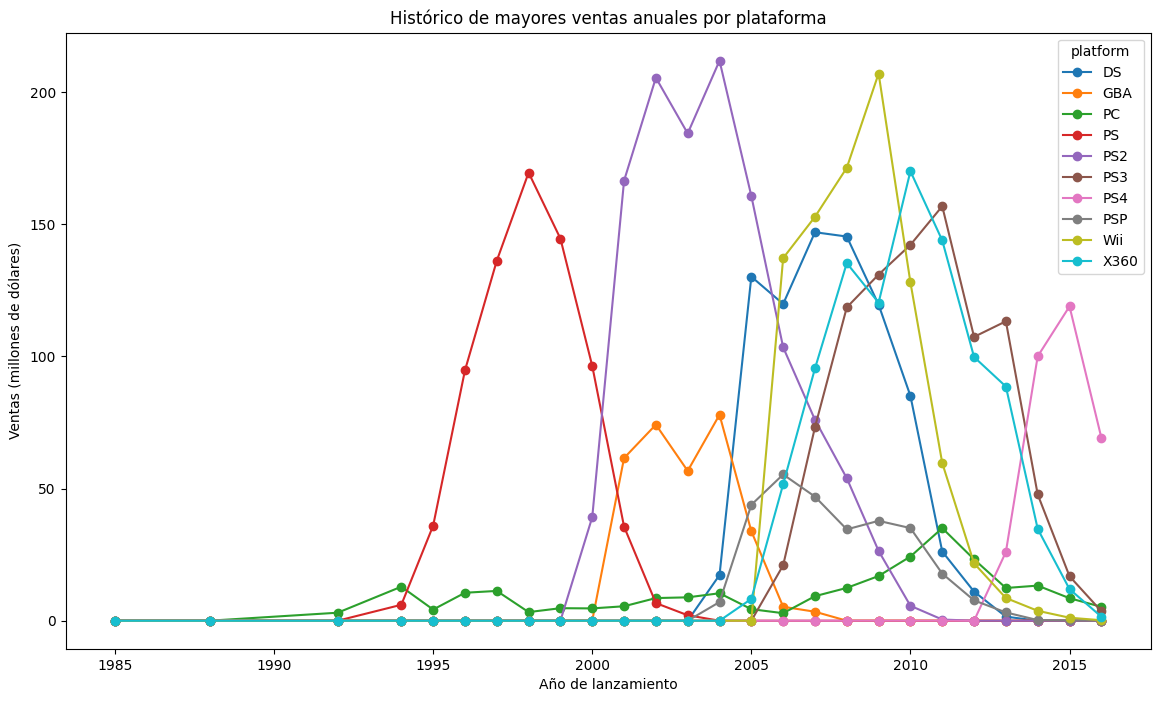

In [90]:
platform_history_per_year(games,platforms_list)

**Comentario:**

En promedio, la mayoría de las plataformas tendían a aparecer cada 5 años, cuyo promedio de vida en el mercado era de 5 años hasta la aparición de una nueva. El año 2004 fue el año en el que se lanzaron más plataformas y el promedio de vida aumenta a más de 8 años en el mercado. La PlayStation históricamente ha sido la consola con mayor solides en el mercado, manteniendo un promedio de vida de más de 5 años llegando a ventas anuales de más de 200 millones de dólares, sin embargo, es en 2005 donde se observa que llega a tener una competencia con Wii y x360.

### Modelo para 2017

In [91]:
# Juegos lanzadas desde 2004
filter_2004=games.query('year_of_release>=2004')

In [92]:
# Modelo para predicciones 2017
model_2017=games[games['year_of_release'].isin(filter_2004['year_of_release'])]

In [93]:
# Total de ingresos por plataforma desde 2004
income_2004_per_platform=model_2017.groupby('platform')['total_sales'].sum().sort_values(ascending=False).reset_index()

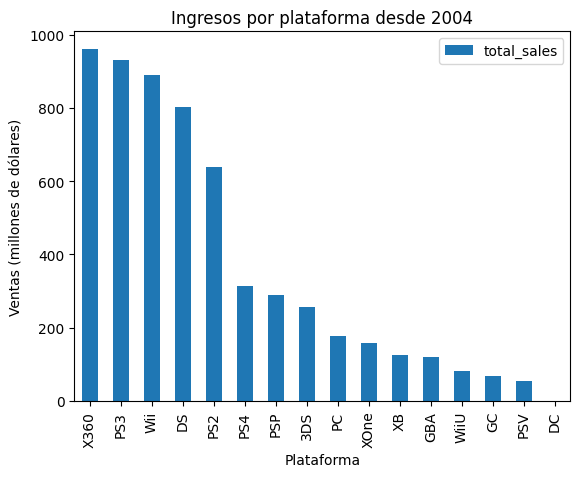

In [94]:
income_2004_per_platform.plot(kind='bar',
                              title='Ingresos por plataforma desde 2004',
                              x='platform',
                              y='total_sales',
                              xlabel='Plataforma',
                              ylabel='Ventas (millones de dólares)')

plt.show()

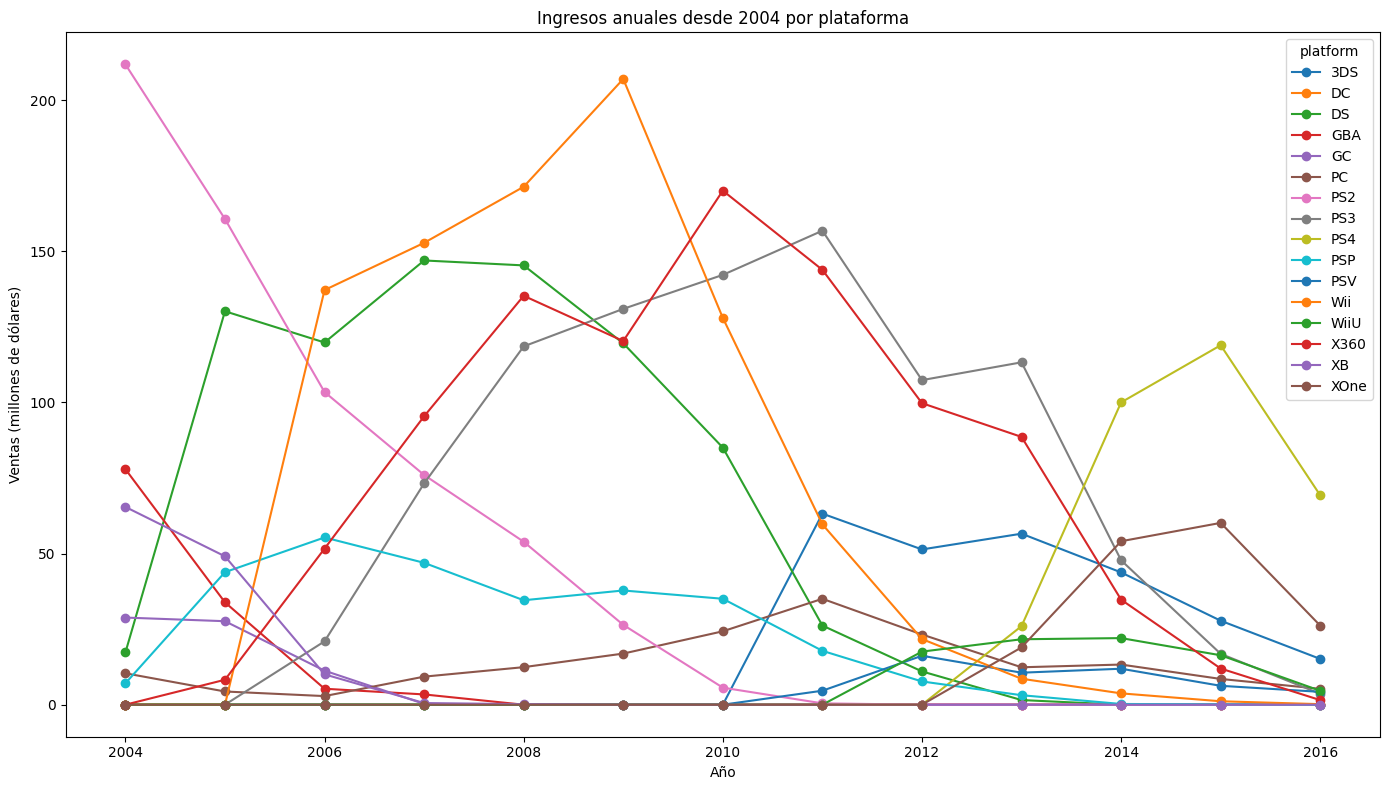

In [95]:
# Ingresos anuales desde 2004 por plataforma
sales_distribution_since_2004=model_2017.groupby(['year_of_release','platform'])['total_sales'].sum().unstack(fill_value=0) 

sales_distribution_since_2004.plot(kind='line',
                                   title='Ingresos anuales desde 2004 por plataforma',
                                   ylabel='Ventas (millones de dólares)',
                                   xlabel='Año',
                                   figsize=(14,8),
                                   style='-o')

plt.tight_layout()
plt.show()

**Comentario:**

Las plataformas X360, PS3 y Wii habían sido las líderes en ventas hasta 2013, pero con la llegada del XOne y el PS4 emperazon a disminuir sus ventas y para 2014 estas se posicionaron como las líderes en ventas, seguidas por el 3DS y la PC. Sin embargo, es de notar que la consola de Sony se ha mantenido como una apuesta segura ya que se ha encontrado históricamente dentro de los líderes de ventas y ha mantendido un periodo de vida bastante sólido.

Estímo que las ventas para las plataformas de PS4 y XOne seguirán creciendo para 2017 por lo que serían las plataformas más rentables, anteponiendo a la PS4 como la líder en la industria.

### Ventas globales por plataforma

In [96]:
# Lista de juegos desde 2004
platforms_since_2004_list=model_2017[model_2017['year_of_release']>=2004]['platform'].to_list()

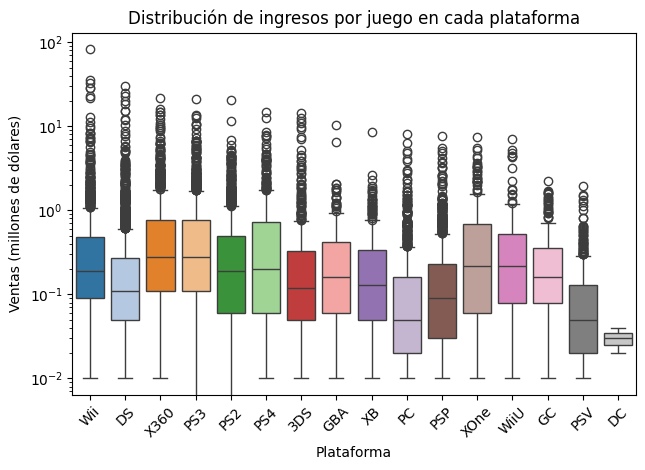

In [97]:
# Función para generar los boxplots de juegos por plataforma
def boxplot_per_platforms (df, platform):
    df_filter=df[df['platform'].isin(platform)]
    
    # Generar paleta de 16 colores pastel
    colors = sns.color_palette("tab20", 16)
    
    # Generar boxplot
    sns.boxplot(data=df_filter, x='platform', y='total_sales', hue='platform', palette=colors, dodge=False)
    plt.title('Distribución de ingresos por juego en cada plataforma')
    plt.xlabel('Plataforma')
    plt.ylabel('Ventas (millones de dólares)')

    max_y=df_filter['total_sales'].max()
    plt.yticks(np.arange(0, max_y + 10, 10))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.yscale('log')
    plt.show()

boxplot_per_platforms(model_2017,platforms_since_2004_list)

In [98]:
# Media de ingreso por plataforma
mean_games=model_2017.pivot_table(index='platform', values='total_sales', aggfunc='mean').reset_index().sort_values(ascending=False, by='total_sales')

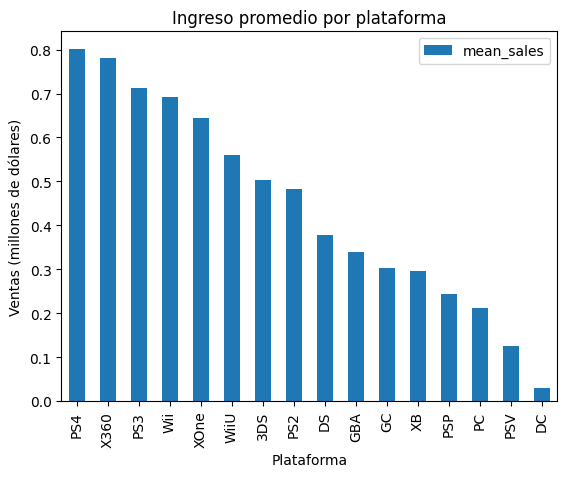

In [99]:
mean_games.plot(kind='bar',
                title='Ingreso promedio por plataforma',
                x='platform',
                y='total_sales',
                xlabel='Plataforma',
                ylabel='Ventas (millones de dólares)')

plt.legend(['mean_sales'])
plt.tight_layout
plt.show()

**Comentario:**

Al contrastar el boxplot con la gráfica de las medias puedo apreciar que son muy puntuales los juegos que llegan a tener "éxito" en las ventas, al mismo tiempo estos resultados permiten analizar con detalle cuáles son esos juegos exitosos en ventas para hacer un análisis sobre a qué categoría pertenecen y la puntuación que le dan los jugadores.

Por otro lado, se aprecia que la PS4 es la consola que más ha generado ingresos en promedio y PC la que genera un menor ingreso promedio.

### Influencia de las reseñas en las ventas

In [100]:
# Filtro para ventas y crítica de la PS4
critic_ps4=games[games['platform']=="PS4"][['critic_score','user_score','total_sales']]

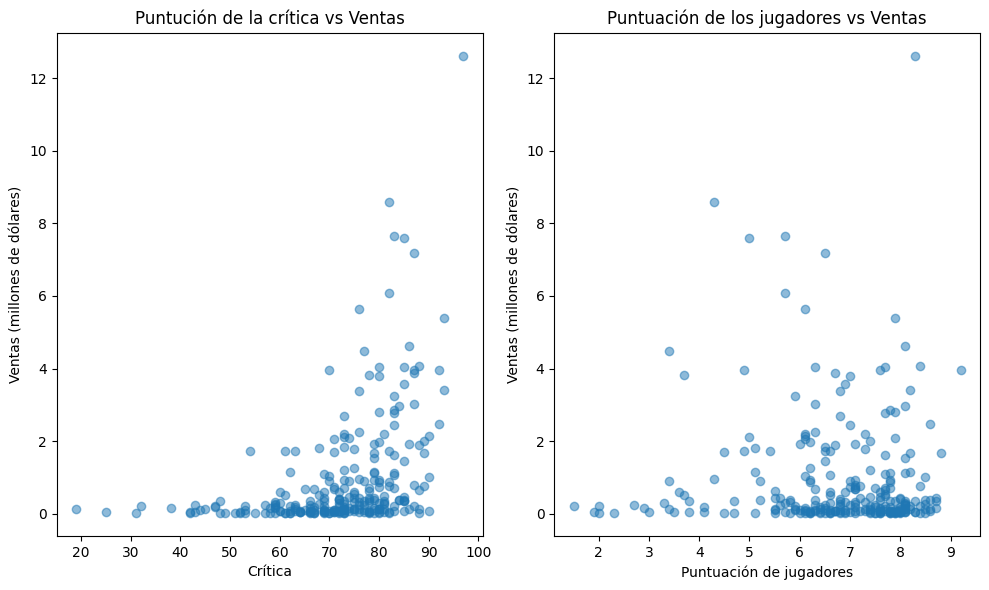

In [101]:
# Gráficos de correlación
fig, axes=plt.subplots(1,2, figsize=(10, 6))
axes[0].scatter(critic_ps4['critic_score'], critic_ps4['total_sales'], alpha=0.5)
axes[0].set_title('Puntución de la crítica vs Ventas')
axes[0].set_xlabel('Crítica')
axes[0].set_ylabel('Ventas (millones de dólares)')

axes[1].scatter(critic_ps4['user_score'], critic_ps4['total_sales'], alpha=0.5)
axes[1].set_title('Puntuación de los jugadores vs Ventas')
axes[1].set_xlabel('Puntuación de jugadores')
axes[1].set_ylabel('Ventas (millones de dólares)')

plt.tight_layout()
plt.show()

In [102]:
# Coeficiente de correlación
print(critic_ps4.corr())

              critic_score  user_score  total_sales
critic_score      1.000000    0.557654     0.406568
user_score        0.557654    1.000000    -0.031957
total_sales       0.406568   -0.031957     1.000000


**Comentario**

En el gráfico de dispersión no se muestra una correlación entre las reseñas y las ventas de los juegos. Esta afirmación se confirma con la matriz realizada que muestra: una correlación baja entre el total de ventas y la puntuación de la crítica (0.40), y una correlación prácticamente nula entre la puntuación de los jugadores y el total de ventas (-0.03).

Estos datos muestran que las reseñas no están relacionadas con las ventas de los videojuegos, por lo que no se podrían considerar como un factor determinante a considerar para la rentabilidad de la plataforma.

### Comparativa entre plataformas con los mismos juegos

Anteriormente se expuso que las ventas no muestran tener una relación con las reseñas de los juegos. Ahora comparo las ventas de los juegos de la plataforma PS4 con los mismos juegos en diferentes plataformas.

In [103]:
# Lista de juegos de PS4
games_ps4_list=games[games['platform']=='PS4']['name'].to_list()

In [104]:
# Plataformas con juegos en común
common_platforms=games[games['name'].isin(games_ps4_list)].pivot_table(index=['platform', 'name'], values='total_sales', aggfunc='sum').reset_index()
print('Las plataformas que tienen juegos en común son:',common_platforms['platform'].unique())

Las plataformas que tienen juegos en común son: ['2600' '3DS' 'DS' 'GC' 'PC' 'PS2' 'PS3' 'PS4' 'PSP' 'PSV' 'Wii' 'WiiU'
 'X360' 'XOne']


In [105]:
# Plataformas a considerar
platforms_for_2017=['PS4','PS3','XOne','X360','3DS','PC']

In [106]:
# Filtrado de plataformas a considerar con juegos en común para 2017
common_platforms_2017=common_platforms[common_platforms['platform'].isin(platforms_for_2017)]

In [107]:
print(common_platforms_2017)
print('\n','Hay',common_platforms['name'].nunique(),'juegos en común para las consolas:',platforms_for_2017)

     platform                                        name  total_sales
1         3DS  adventure time: finn & jake investigations         0.09
2         3DS                       angry birds star wars         0.33
3         3DS                                     fifa 14         0.23
4         3DS                                     fifa 15         0.46
5         3DS                lego batman 3: beyond gotham         0.45
...       ...                                         ...          ...
1172     XOne                                    wwe 2k16         0.59
1173     XOne                                    wwe 2k17         0.26
1174     XOne                                      xcom 2         0.04
1175     XOne                         zombie army trilogy         0.11
1176     XOne                                      zombiu         0.01

[1037 rows x 3 columns]

 Hay 392 juegos en común para las consolas: ['PS4', 'PS3', 'XOne', 'X360', '3DS', 'PC']


In [108]:
# Total de ventas para los juegos en común
games_per_platforms_2017=common_platforms_2017.groupby('name')['total_sales'].sum().sort_values(ascending=False)

In [109]:
# Top 10 juegos con mayores ventas para las plataformas en común
top_10_games_per_platforms_2017=games_per_platforms_2017[:10].reset_index()
print(top_10_games_per_platforms_2017)

                             name  total_sales
0              grand theft auto v        56.58
1            call of duty: ghosts        27.04
2       call of duty: black ops 3        25.67
3  call of duty: advanced warfare        21.97
4                       minecraft        21.53
5     the elder scrolls v: skyrim        21.14
6                         fifa 16        16.30
7                         fifa 15        16.21
8                         fifa 14        15.48
9                   battlefield 4        13.94


In [110]:
# Top juegos más vendidos con plataformas en común
common_games_2017=common_platforms_2017[common_platforms_2017['name'].isin(top_10_games_per_platforms_2017['name'])]

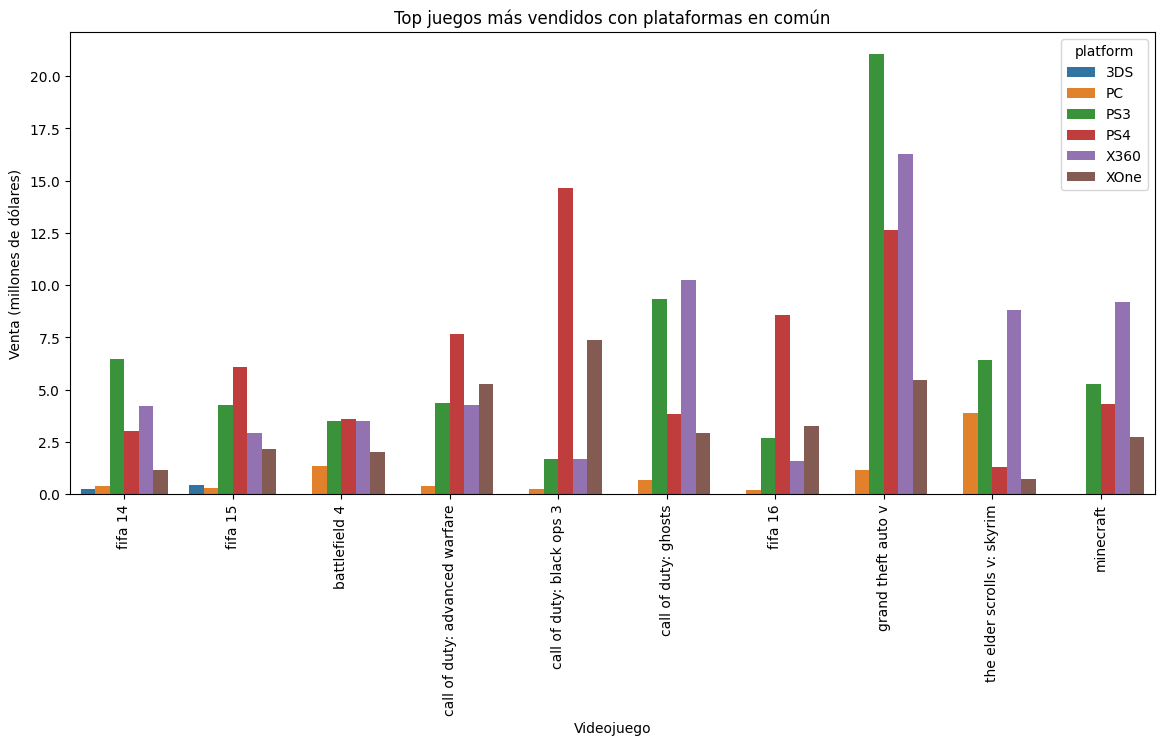

In [111]:
plt.figure(figsize=(14,6))
sns.barplot(data=common_games_2017, x='name', y='total_sales', hue='platform')

plt.title('Top juegos más vendidos con plataformas en común')
plt.xlabel('Videojuego')
plt.ylabel('Venta (millones de dólares)')
plt.xticks(rotation=90)
plt.show()

**Comentario:**

En el análisis de las ventas de los juegos en común para las distintas plataformas, se tomó en cuenta; las 3 consolas más relevantes en el modelo para 2017 (PS4, XOne, 3DS y PC); y los 10 juegos más vendidos en todas las plataformas. Con estos datos se puede apreciar que históricamente, la plataforma de Sony, ha sido la preferida por los jugadores, se aprecia que (de las consolas más recientes) la PS4 supera en ventas a la XOne.

### Distribución general por género

In [112]:
# Total de ventas por género
sales_per_genre=model_2017.groupby('genre')['total_sales'].sum().sort_values(ascending=False)

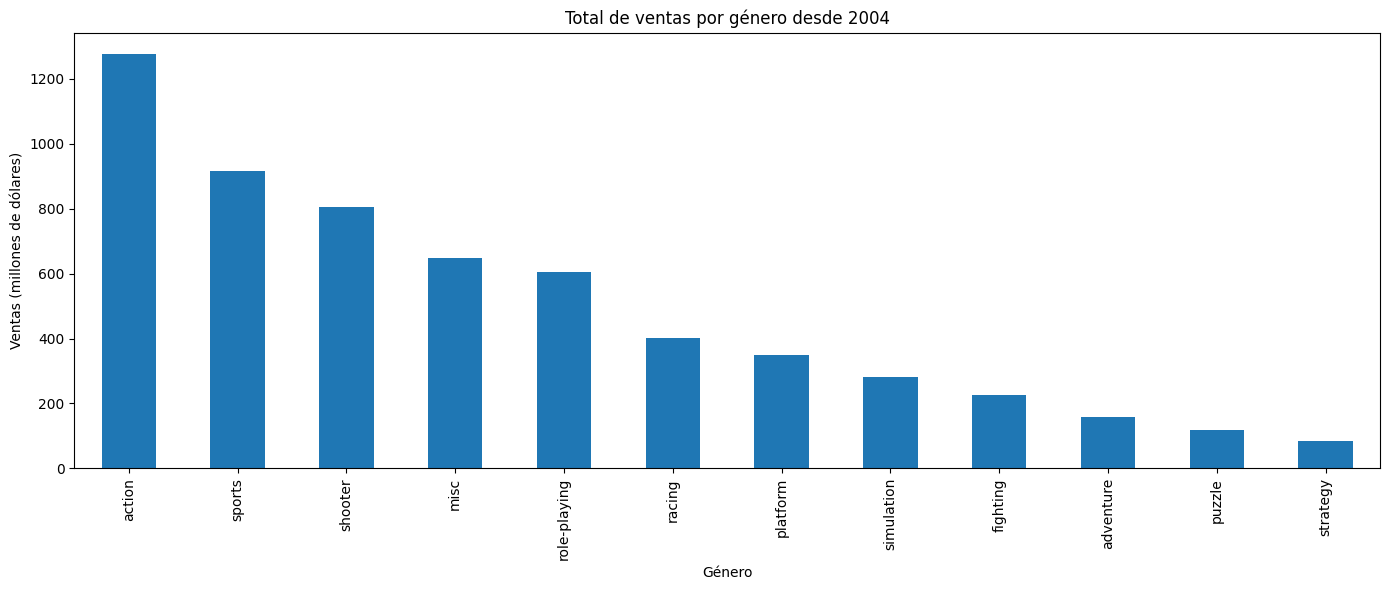

In [113]:
plt.figure(figsize=(14,6))

sales_per_genre.plot(kind='bar',
                      title='Total de ventas por género desde 2004',
                      xlabel='Género',
                      ylabel='Ventas (millones de dólares)')

plt.tight_layout()
plt.show()

In [114]:
model_2017[model_2017['genre']=="sports"]['total_sales']

0        82.54
3        32.77
13       22.70
15       21.80
77        8.58
         ...  
16656     0.01
16676     0.00
16688     0.01
16700     0.01
16711     0.01
Name: total_sales, Length: 1489, dtype: float64

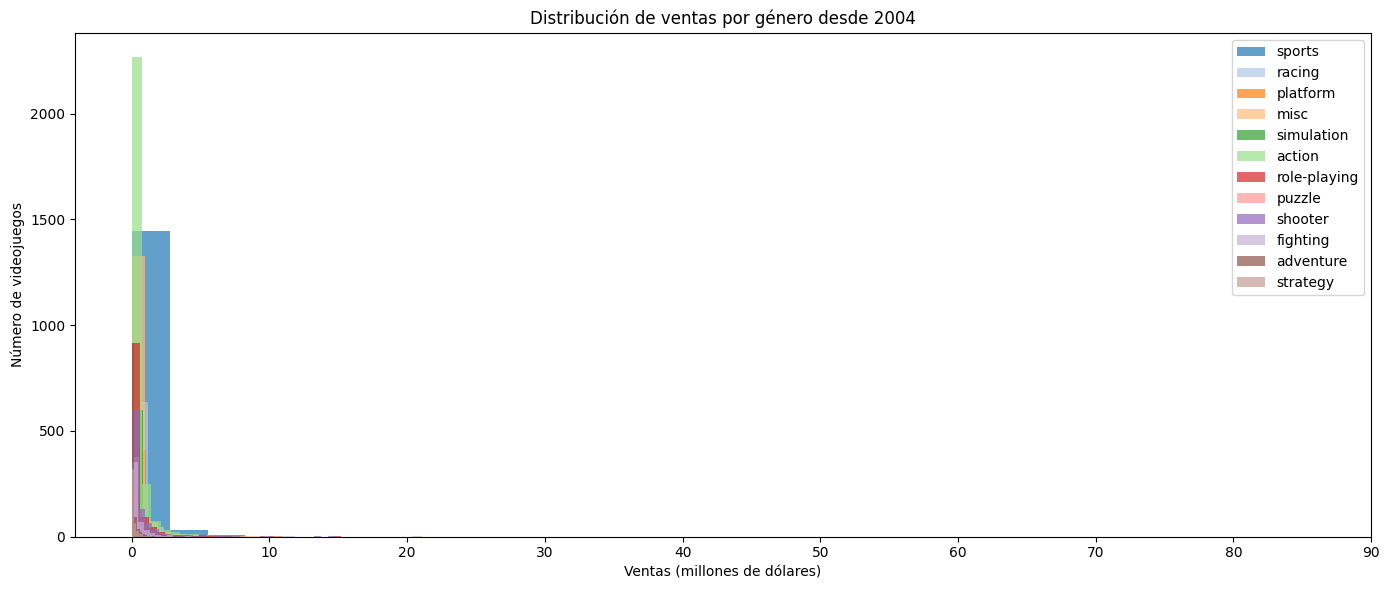

In [115]:
# Distribución por género (histograma)
genres=model_2017['genre'].unique().tolist()
colors=sns.color_palette('tab20',12)

plt.figure(figsize=(14,6))

for genre, color in zip(genres, colors):
    
    data=model_2017[model_2017['genre']==genre]['total_sales']
    
    
    plt.hist(data, label=genre, color=color, alpha=0.7, bins=30)

plt.title('Distribución de ventas por género desde 2004')
plt.ylabel('Número de videojuegos')
plt.xlabel('Ventas (millones de dólares)')
plt.xticks(np.arange(0, games['total_sales'].max() + 10, 10))
plt.tight_layout()
plt.legend()
plt.show()

In [116]:
# Ingresos máximos por génerp
for genre in genres :
    data=model_2017[model_2017['genre']==genre]['total_sales'].max()
    number=len(model_2017[model_2017['genre']==genre])
    print(f'Del género {genre} el juego con mayor numero de ventas tuvo ingresos por: ${data}, de un total de {number} títulos')

Del género sports el juego con mayor numero de ventas tuvo ingresos por: $82.53999999999999, de un total de 1489 títulos
Del género racing el juego con mayor numero de ventas tuvo ingresos por: $35.519999999999996, de un total de 709 títulos
Del género platform el juego con mayor numero de ventas tuvo ingresos por: $29.8, de un total de 489 títulos
Del género misc el juego con mayor numero de ventas tuvo ingresos por: $28.91, de un total de 1453 títulos
Del género simulation el juego con mayor numero de ventas tuvo ingresos por: $24.67, de un total de 671 títulos
Del género action el juego con mayor numero de ventas tuvo ingresos por: $21.05, de un total de 2700 títulos
Del género role-playing el juego con mayor numero de ventas tuvo ingresos por: $18.24, de un total de 1127 títulos
Del género puzzle el juego con mayor numero de ventas tuvo ingresos por: $15.28, de un total de 424 títulos
Del género shooter el juego con mayor numero de ventas tuvo ingresos por: $14.73, de un total de 9

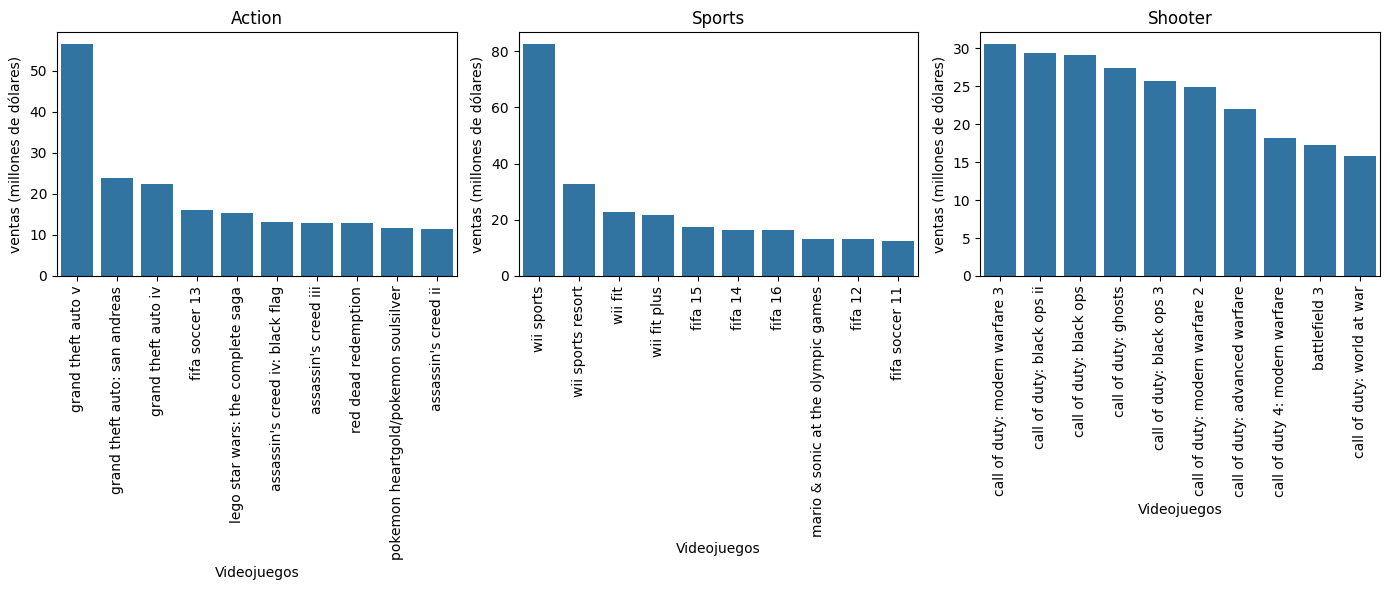

In [117]:
# Top juegos con mayores ingresos por género
fig, axs=plt.subplots(1,3, figsize=(14,6))
sns.barplot(data=model_2017[model_2017['genre']=='action'].groupby('name')['total_sales'].sum().sort_values(ascending=False).head(10), ax=axs[0])
axs[0].set_title('Action')
axs[0].set_ylabel('ventas (millones de dólares)')
axs[0].set_xlabel('Videojuegos')
axs[0].tick_params(axis='x', rotation=90)

sns.barplot(data=model_2017[model_2017['genre']=='sports'].groupby('name')['total_sales'].sum().sort_values(ascending=False).head(10), ax=axs[1])
axs[1].set_title('Sports')
axs[1].set_ylabel('ventas (millones de dólares)')
axs[1].set_xlabel('Videojuegos')
axs[1].tick_params(axis='x', rotation=90)

sns.barplot(data=model_2017[model_2017['genre']=='shooter'].groupby('name')['total_sales'].sum().sort_values(ascending=False).head(10), ax=axs[2])
axs[2].set_title('Shooter')
axs[2].set_ylabel('ventas (millones de dólares)')
axs[2].set_xlabel('Videojuegos')
axs[2].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

Para poder generalizar si action es el género con mayores ventas y strategy el juego con menores ventas, haré una "prueba t" para determinar si la diferencia es estadísticamente significativa.

Prueba de Hipótesis 1:
* H₀: Las ventas del género "action" no son diferentes que las del resto de géneros.
* H₁: Las ventas del género "action" son diferentes que las del resto de géneros.

Prueba de Hipótesis 2:
* H₀: Las ventas del género "strategy" no son diferentes que las del resto de géneros.
* H₁: Las ventas del género "strategy" son diferentes que las del resto de géneros.

In [118]:
# Prueba de hipótesis 

def diferencia_entre_género (df,genero_objetivo,alpha):
    
    # Formar grupos
    grupo_objetivo=df[df['genre']==genero_objetivo]['total_sales']
    grupos_a_comparar=df[df['genre']!=genero_objetivo]['total_sales']
    
    # Prueba de levene
    stat_levene, p_levene=levene(grupo_objetivo, grupos_a_comparar)
    
    if p_levene < alpha:
        equal_var=False
    else:
        equal_var=True
        
    # prueba t
    t_stat, p_value=st.ttest_ind(grupo_objetivo, grupos_a_comparar, equal_var=equal_var)
    
    print('Difieren las ventas del género', genero_objetivo, 'con las del resto de géneros?')
    print(f'El promedio de ingresos del género {genero_objetivo} es de: ${grupo_objetivo.mean()}')
    print(f'El promedio de ingresos de los demás géneros es de: ${grupos_a_comparar.mean()}')
    
    # Resultado prueba de levene
    if p_levene < alpha:
        print('Las varianzas son diferentes')
    else:
        print('Las varianzas son iguales')
        
    # Resultado de hipótesis
    print(f'Valor p:{p_value}')
    
    if p_value < alpha:
        print('Se rechaza la hipótesis nula')
    else:
        print('No se rechaza la hipótesis nula')

In [119]:
# Prueba hipótesis 1
diferencia_entre_género(model_2017,'action',0.05)

Difieren las ventas del género action con las del resto de géneros?
El promedio de ingresos del género action es de: $0.4734037037037037
El promedio de ingresos de los demás géneros es de: $0.49227102303160153
Las varianzas son iguales
Valor p:0.5740777510388199
No se rechaza la hipótesis nula


In [120]:
# Prueba hipótesis 2
diferencia_entre_género(model_2017,'strategy',0.05)

Difieren las ventas del género strategy con las del resto de géneros?
El promedio de ingresos del género strategy es de: $0.18845814977973568
El promedio de ingresos de los demás géneros es de: $0.4997824022105172
Las varianzas son diferentes
Valor p:9.792225507754495e-43
Se rechaza la hipótesis nula


**Comentario:**

Los géneros que representan mayores ventas son: action, sports y shooter. Al analizar con mayor detenimiento la distribución de las ventas puedo percatarme que a cada género lo caracteriza:

* Acción: a este género lo caracteriza la gran variedad de títulos que tiene en donde más del 82% de los juegos llegan a tener ventas inferiores a los 2 millones de dólares, sin embargo, se le puede ver a este género como el más popular ya que sus ventas acumuladas lo hacen ser el género líder en ventas en el mercado. En el top 10 juegos con mayores ingresos por género se puede apreciar tanto la variedad de títulos como el best seller de este género (GTA V).

* Sports: en este género la mayoría de los juegos se encuentran en un rango de ventas de 0-3 millones, sin embargo, se puede apreciar que sus títulos que representan mayores ingresos son los diferentes "fifa" y algunos juegos de la plataforma de nintendo. Este géneo puede ser el más sólido en ventas, ya que se atiene puntualmente a la popularidad de los deportes.

* Shooter: este género es muy particular ya que se le ve como el 3° género con mayores ingresos, aunque aparentemente el núemro de títulos con respecto a sus ventas no parece ser muy significativo, su éxito se encuentra muy focalizado en los títulos de "call of duty" ya que es el único en donde se puede apreciar que, del top de juegos con mayores ingresos por género, 7/10 representan ventas por encima de los 20 millones.

Los géneros que representan menores ventas son: strategy, puzzle y adventure. Al analizar con mayor detenimiento la distribución de las ventas puedo percatarme que a cada género lo caracteriza:

* Strategy: este género es el que menos variedad de títulos tiene y aparenta ser el de menor popularidad entre los jugadores ya que más del 80% de los títulos tienen ingresos inferiores a 1 millón de dólares.

* Puzzle: de este género son más de 350 juegos los que generan ganancias de entre 0-1.5 millones de dólares, siendo la plataforma "DS" la que concentra la mayoría de los títulos.

* Adventure: este género representa mayores ventas que el "puzzle", aunque son 811 juegos los que representan ingresos inferiores a 1 millón de dólares, las ventas acumuladas de estos hacen que tenga mayores ventas totales. 

Finalmente se puede apreciar que aunque el género "action" tuvo mayores ingresos que los otros géneros, esta diferencia no es estadísticmanete significativa. Por otro lado, el género "stretegy", que tuvo menores ingresos, si representa una diferencia estadísticmaente significativa con la del resto de géneros.

## Perfil de usuario para cada región

### Plataformas principales por región

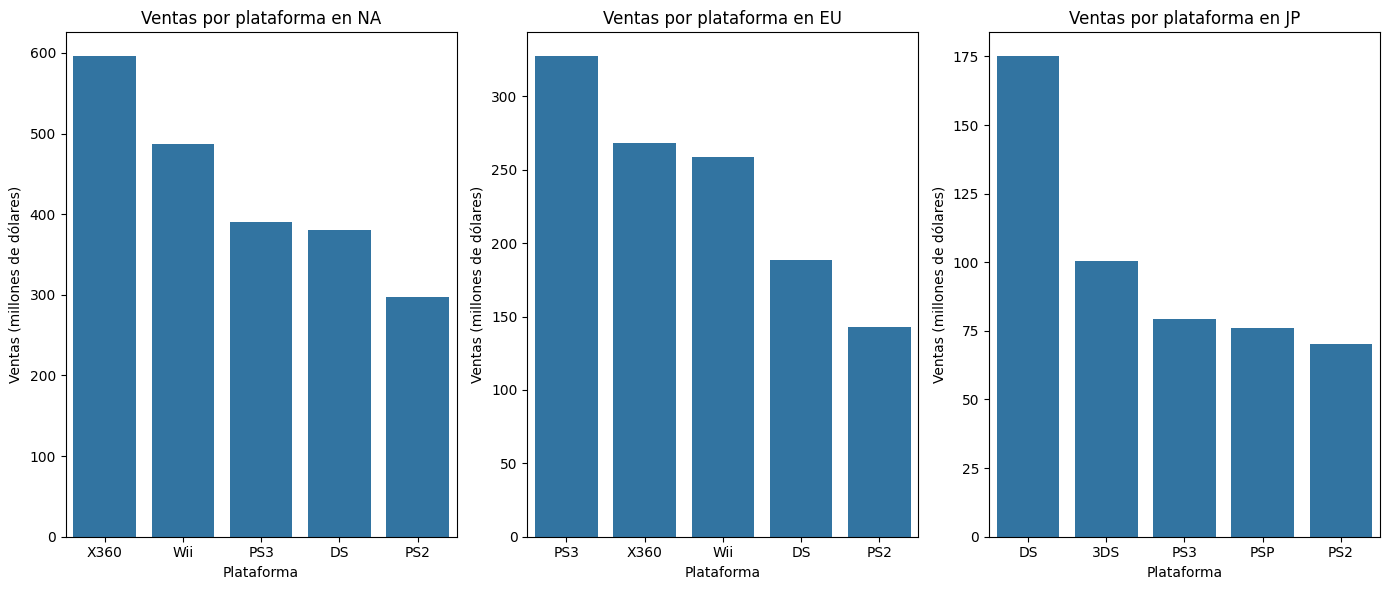

In [121]:
# Gráfico de top plataformas con mayores ventas por región
fig, axs=plt.subplots(1,3, figsize=(14,6))

sns.barplot(data=model_2017.groupby('platform')['na_sales'].sum().sort_values(ascending=False)[:5], ax=axs[0])
axs[0].set_title('Ventas por plataforma en NA')
axs[0].set_ylabel('Ventas (millones de dólares)')
axs[0].set_xlabel('Plataforma')

sns.barplot(data=model_2017.groupby('platform')['eu_sales'].sum().sort_values(ascending=False)[:5], ax=axs[1])
axs[1].set_title('Ventas por plataforma en EU')
axs[1].set_ylabel('Ventas (millones de dólares)')
axs[1].set_xlabel('Plataforma')

sns.barplot(data=model_2017.groupby('platform')['jp_sales'].sum().sort_values(ascending=False)[:5], ax=axs[2])
axs[2].set_title('Ventas por plataforma en JP')
axs[2].set_ylabel('Ventas (millones de dólares)')
axs[2].set_xlabel('Plataforma')

plt.tight_layout()
plt.show()

**Comentario**

En lo que a las ventas por región se refiere, NA es la región que genera mayores ventas, demostrando ser el mercado más grande en el consumo de videojuegos, de manera puntual la X360 es la plataforma que mayor ingresos ha generado, aparentando ser la plataforma de microsoft la preferida por este mercado.

Por otro lado, en EU lidera la PS3 el top de ventas seguida, tal parece que las plataformas de sony, microsoft y nintendo han liderado en este mercado y en el de NA (auqnue en diferente orden). 

Finalmente, para el mercado JP las plataformas de nintendo son las más destacables siendo la DS el principal exponente para esta región. 

Cabe resaltar que de las consolas de la nueva generación (XOne, PS4 y 3DS), la 3DS es la única que ha comenzado a impactar en el top de ventas, mostrando la preferencia de JP por las plataformas de nintendo.

### Géneros principales

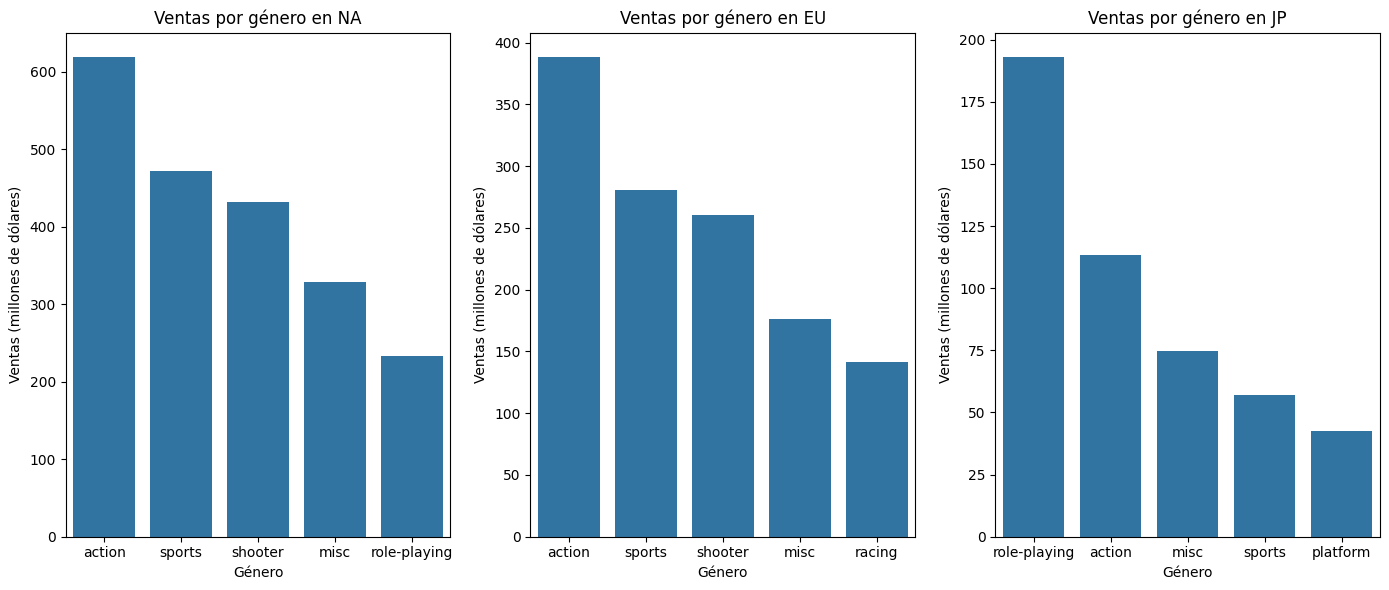

In [122]:
# Gráfico de top géneros con mayores ventas por región
fig, axs=plt.subplots(1,3, figsize=(14,6))

sns.barplot(data=model_2017.groupby('genre')['na_sales'].sum().sort_values(ascending=False)[:5], ax=axs[0])
axs[0].set_title('Ventas por género en NA')
axs[0].set_ylabel('Ventas (millones de dólares)')
axs[0].set_xlabel('Género')

sns.barplot(data=model_2017.groupby('genre')['eu_sales'].sum().sort_values(ascending=False)[:5], ax=axs[1])
axs[1].set_title('Ventas por género en EU')
axs[1].set_ylabel('Ventas (millones de dólares)')
axs[1].set_xlabel('Género')

sns.barplot(data=model_2017.groupby('genre')['jp_sales'].sum().sort_values(ascending=False)[:5], ax=axs[2])
axs[2].set_title('Ventas por género en JP')
axs[2].set_ylabel('Ventas (millones de dólares)')
axs[2].set_xlabel('Género')

plt.tight_layout()
plt.show()

**Comentario**

Nuevamente, se ve a la región de NA como la lider en ventas de forma general. En esta ocasión NA y EU comparten los mismos 4 géneros principales, aunque en diferente proporción de ingresos, esto sugiere que ambas regiones tienen la misma preferencia por estos géneros. El mercado de JP difiere en la rentabilidad de dichos géneros, mostrando una notable inclinación por el role-playing, esto se puede deber a una diferencia cultural en la que hay ciertos géneros que son mejor aceptados.

### Relación entre la calificación de ESRB y las ventas por región

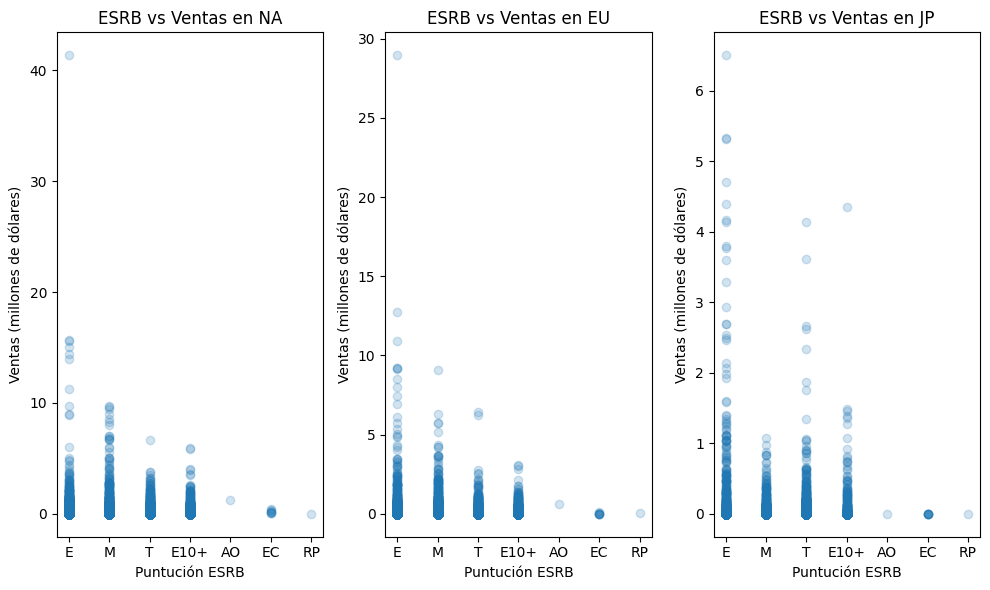

In [123]:
# Se eliminan los valores nulos para poder realizar el gráfico
model_2017_clean = model_2017[model_2017['rating'].notna()]

# Gráficos de correlación
fig, axes=plt.subplots(1,3, figsize=(10, 6))
axes[0].scatter(model_2017_clean['rating'], model_2017_clean['na_sales'], alpha=0.2)
axes[0].set_title('ESRB vs Ventas en NA')
axes[0].set_xlabel('Puntución ESRB')
axes[0].set_ylabel('Ventas (millones de dólares)')

axes[1].scatter(model_2017_clean['rating'], model_2017_clean['eu_sales'], alpha=0.2)
axes[1].set_title('ESRB vs Ventas en EU')
axes[1].set_xlabel('Puntución ESRB')
axes[1].set_ylabel('Ventas (millones de dólares)')

axes[2].scatter(model_2017_clean['rating'], model_2017_clean['jp_sales'], alpha=0.2)
axes[2].set_title('ESRB vs Ventas en JP')
axes[2].set_xlabel('Puntución ESRB')
axes[2].set_ylabel('Ventas (millones de dólares)')

plt.tight_layout()
plt.show()

**Comentario**

Los juegos con clasificación "E" son los más vedidos a nivel global, especialmente en las regiones de NA y EU. La segunda categoría con mayor impacto en las ventas es la "M", nuevamente con mayor énfasis en las regiones de NA y EU, lo que sugiere que los títulos con mayor nivel de volencia son mejor recibidos en estas regiones. 

Finalmente, se puede apreciar que el rango de ventas es más alto en NA, denotando que este puede ser un mercado más grande o con mayor consumo de videojuegos. La clasificación ESRB si influye en las ventas, siendo la clasificación "E" la que llega a causar mayor rendimiento. Cabe resaltar que las diferencias culturales en las distintas regiones pueden afectar el desempeño de algunos títulos, como se puede ver en el caso de JP, siendo la clasificación "T" la que tiene mayor impacto en comparación con la "E".

## Prueba de hipótesis 

A continuación se realizaran dos pruebas de hipótesis para poder visualizar si las calificaciones promedio de los usuarios de las plataformas XOne y PC son las mismas, y si las calificaciones promedio de los usuarios para los géneros de Acción y Deportes difieren.

Prueba de Hipótesis 1: diferencia entre calificaciones XOne y PC
* H₀: No hay diferencia en las calificaciones de los usuarios entre las plataformas XOne y PC.
* H₁: Hay diferencia en las calificaciones de los usuarios entre las plataformas XOne y PC.

Prueba de Hipótesis 2: diferencia entre calificaciones Acción y Deportes
* H₀: No hay diferencia en las calificaciones de los usuarios entre los géneros acción y deporte.
* H₁: Hay diferencia en las calificaciones de los usuarios entre los géneros acción y deporte.

Para la prueba de hipótesis se emplea una prueba t de dos colas ya que lo que se está buscando es saber si existe una diferencia estadísticamente significativa entre ambos grupos de plataforma o género.

In [124]:
# Función para prueba de hipóteis 

def prueba_hipótesis_calif_usuarios (df, columna, grupo_1, grupo_2, alpha):
       
    # Formar grupos
    primer_grupo=df[df[columna]==grupo_1]['user_score']
    segundo_grupo=df[df[columna]==grupo_2]['user_score']
    
    # Prueba de Levene
    stat_levene, p_levene=levene(primer_grupo, segundo_grupo)
    
    if p_levene < alpha:
        equal_var=False
    else:
        equal_var=True
    
    # Prueba t
    t_stat, p_value=st.ttest_ind(primer_grupo, segundo_grupo, equal_var=equal_var)
    
    
    print(f'Difieren las calificaciones de los usuarios entre {grupo_1} y {grupo_2}')
    print(f'El promedio de calificaciones para {grupo_1} es de {primer_grupo.mean()}')
    print(f'El promedio de calificaciones para {grupo_2} es de {segundo_grupo.mean()}')
    
    # Resultado prueba Levene
    if p_levene < alpha:
        print('Las varianzas son diferentes')
    else:
        print('Las varianzas son iguales')
    
    # Resultado prueba t
    if p_value < alpha:
        print('Se rechaza la hipótesis nula')
    else:
        print('No se rechaza la hipótesis nula')
    

In [125]:
# Prueba de hipótesis 1
prueba_hipótesis_calif_usuarios(games, 'platform', 'XOne', 'PC', 0.05)

Difieren las calificaciones de los usuarios entre XOne y PC
El promedio de calificaciones para XOne es de 6.521428571428572
El promedio de calificaciones para PC es de 7.062467532467533
Las varianzas son iguales
No se rechaza la hipótesis nula


In [126]:
# Prueba de hipótesis 2
prueba_hipótesis_calif_usuarios(games, 'genre', 'action', 'sports', 0.05)

Difieren las calificaciones de los usuarios entre action y sports
El promedio de calificaciones para action es de 7.054043715846995
El promedio de calificaciones para sports es de 6.96119673617407
Las varianzas son iguales
No se rechaza la hipótesis nula


**Comentario**

**Los resultados para la hipóteis 1** muestran que no hay diferencia estadísticamente significativa entre las calificaciones de los usuarios para las plataformas de XOne y PC.

**Los resultados para la hipóteis 2** muestran que no hay diferencia estadísticamente significativa entre las calificaciones de los usuarios para los géneros de acción y deportes.

## Conclusión

Los años 2008 y 2009 marcaron el auge del mercado en cuanto a lanzamientos de videojuegos. Tradicionalmente, las plataformas tenían un ciclo de vida promedio de 5 años, aunque desde 2004 este promedio aumentó a más de 8 años, evidenciando una mayor permanencia en el mercado.

PlayStation históricamente ha demostrado ser la consola más sólida del mercado, con una larga permanencia y altas ventas anuales. A partir de 2005, enfrenta una competencia directa con Wii y X360, consolidando así un nuevo ciclo generacional en la industria.

Hata 2013, PS3, X360 y Wii lideraban las ventas; sin embargo, fueron reemplazadas por PS4 y XOne desde 2014, seguidas por 3DS y PC, donde Sony se ha mantiene como líder histórico, posicionando a su consola como la de mayor rentabilidad y con mayor permanencia. Durante lo transcurrido de 2016 la PS4 ha generado ventas por $69.25 millones, mientras que XOne lleva $26.15 millones y 3DS $15.13 millones. Con estos datos se estima que PS4 y XOne continuarán dominando el mercado hasta al menos 2017, con una proyección favorable para la PS4 como la más rentable del periodo.

En cuanto a los videojuegos, se encontró que la puntuación otrogada por los críticos y los usuarios no es un factor relacionado con el éxito en ventas. Se encontró que los juegos con mayores ventas en común para las plataformas más exitosas de este periodo son: GTA V, call of duty, minecraft, the elder scrolls v, fifa y battlefield 4.

Varios de estos títulos se encuentran dentro de los géneros con mayor rentabilidad en el mercado siendo; acción, el de mayor diversidad en títulos y popularidad en el mercado; deporte, con el fifa como su mayor representante; y shooter, representado por el impacto en ventas de los call of duty. 

Analizando el impacto en ventas por región se destaca que en el mercado de NA es el de mayor tamaño y rentabilidad. Los mercados de NA y EU comparten las plataformas: X360, Wii y PS3 como las más destacadas, junto con los géneros: acción, deporte y shooter. Sin emabrgo, la región de JP es la excepción a esto, ya que son las plataformas de nintendo las que gobiernan el mercado junto con el género de role-playing como el best seller. 

Los títulos con clasificación "E" son los mejor aceptados a nivel global, particularmente en NA y EU se observa un buen recibimiento de la clasificación "M", lo que sugiere mejor aceptación en lo que a temas de violencia respecta. Nuevamente se observa una diferencia con el mercado de JP donde es la clasificación "T" la que tiene mejor aceptación junto con la "E". Estos datos sugieren contemplar las diferencias culturales como una variable que puede afectar el recibimeinto de títulos con mayor nivel de violencia en distintos mercados.

Las pruebas de hipotesis en cuanto a la diferencia de calificaciones de los usuarios entre algunos aspectos de las plataformas de XOne y PC mostraron no ser significativas.

Finalmente, con estos datos sugiero que para 2017 se debe de considerar para las campañas y/o futuros proyectos; PS4 y XOne como las plataformas más rentables; NA, como el mercado más sólido; acción, deporte y shooter, como los géneros con mayor impacto en NA y EU; y JP como un mercado particularmente preferente por las plataformas de nintendo y títulos con menor grado de violencia.  